### Time Signal을 input으로 넣고 Time+PSD를 Loss로 설정
#### X에 맞춰서 y를 scaling (X, y 각각 scaling 했을 때 학습이 잘 안됨)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.signal import welch

import sys
sys.path.append('../../../../tool_code/function/') # "~~/tool_code/plot/" (상대 경로)

from DataPlot import Data_Load_Plot, Result_Plot, Train_Loss_Plot
from Scaling import time_scaling, time_inv_scaling

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Contaminated_data.shape: (1000, 4000)
Clean_data.shape: (1000, 4000)


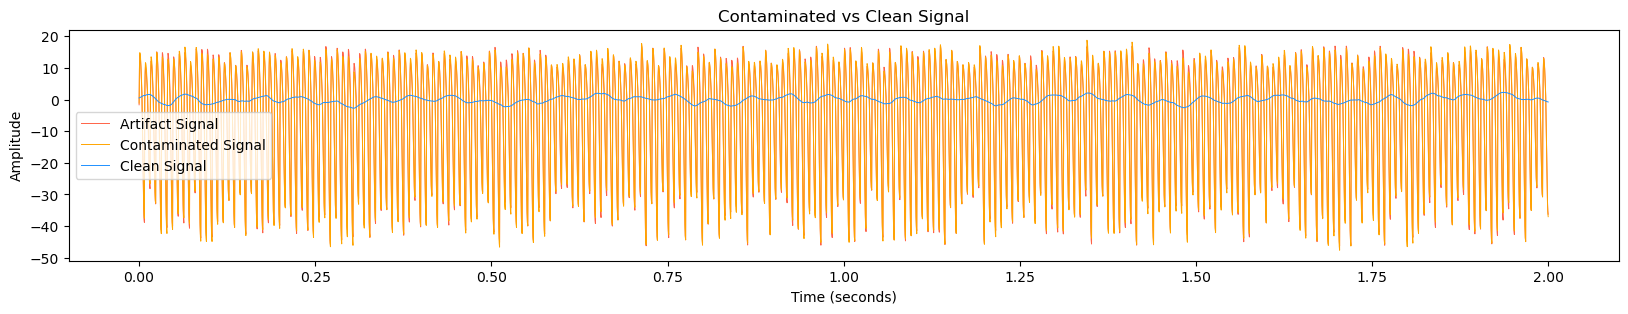

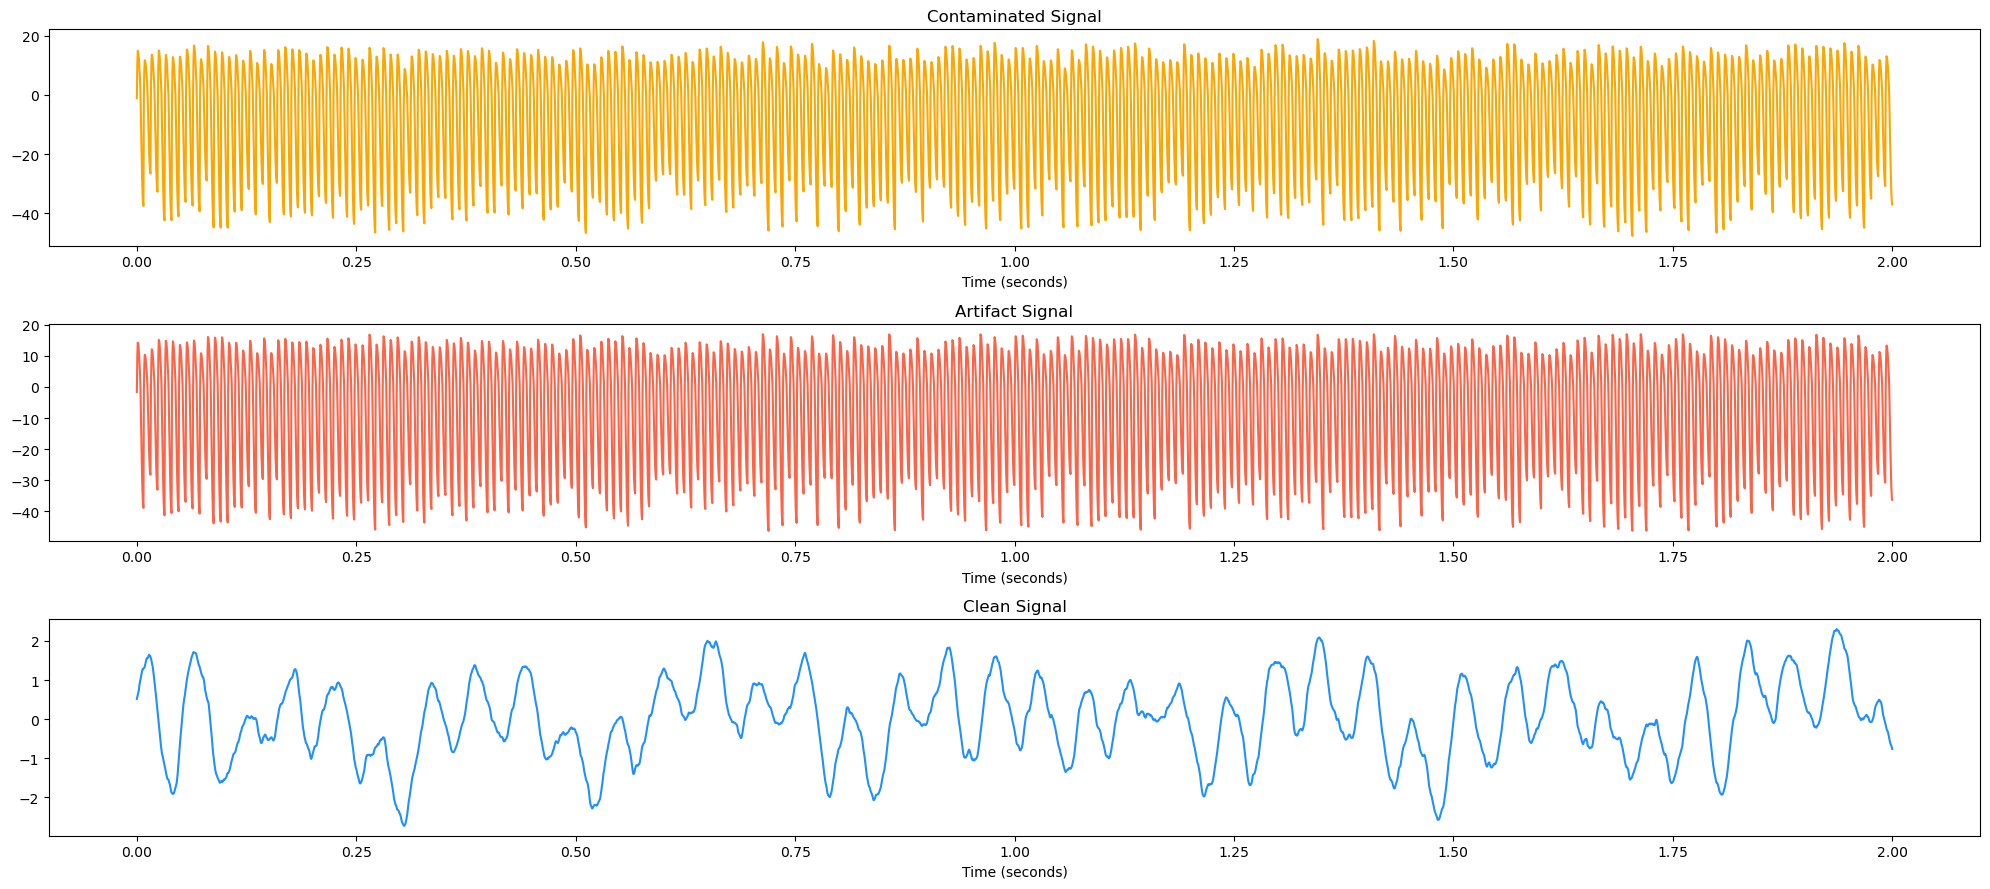

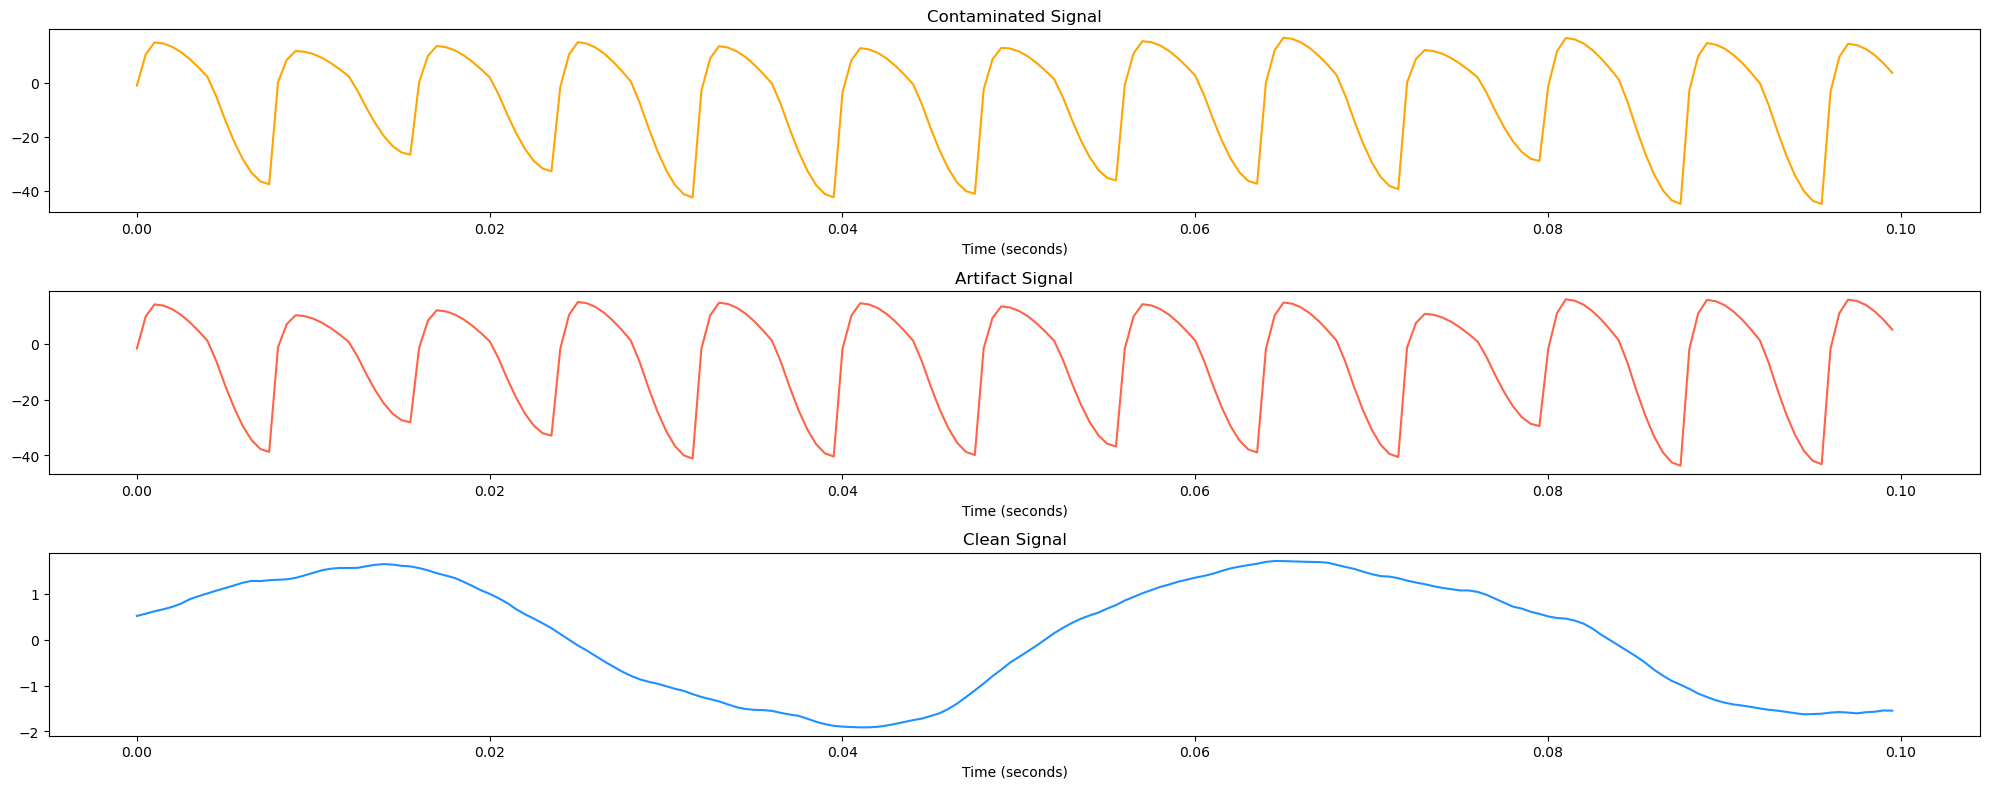

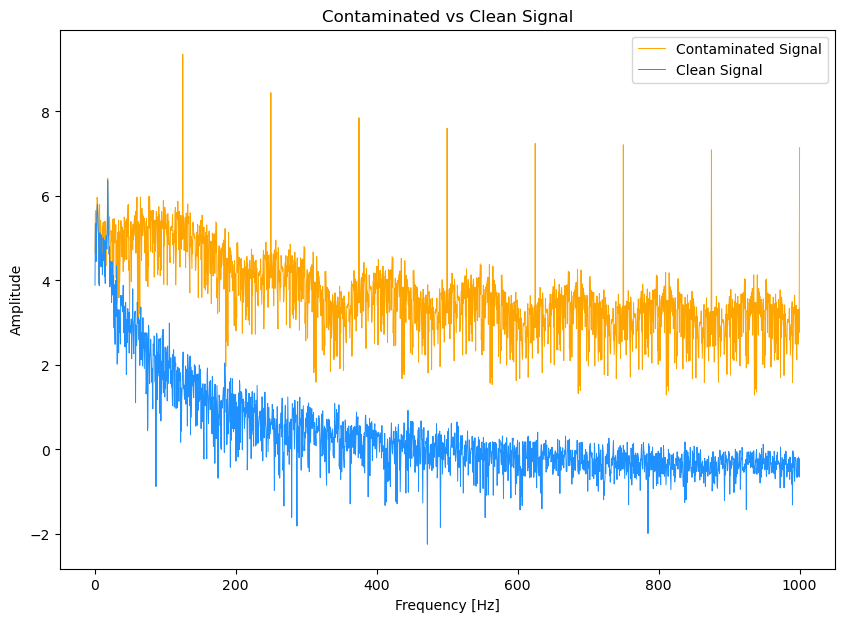

In [2]:
# 데이터 load & plot
datapath='../../../../data/synthetic_data/'

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

In [3]:
# Data Standard Scaling
X, y, scaler_x, scaler_y = time_scaling(Contaminated_data, Clean_data, standard='x')

X: (1000, 4000)
y: (1000, 4000)


In [4]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

# 차원 추가 (LSTM은 세번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1]) # Batch x length x 1
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
y_train = y_train.reshape(y_train.shape[0], 1, y_train.shape[1]) # Batch x length x 1
y_test = y_test.reshape(y_test.shape[0], 1, y_test.shape[1])

print("<Unsqueezed>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T x 1 , y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

<Original>
-----------------------------
X_train shape: (800, 4000)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 4000)
y_test shape: (200, 4000)
-----------------------------
<Unsqueezed>
-----------------------------
X_train shape: (800, 1, 4000)
y_train shape: (800, 1, 4000)
-----------------------------
X_test shape: (200, 1, 4000)
y_test shape: (200, 1, 4000)
-----------------------------


In [5]:
# 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding=1),
            nn.GELU(),
            nn.Conv1d(16, 32, 3, padding=1),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Conv1d(32, 16, 3, padding=1),
            nn.GELU(),
            nn.Conv1d(16, 1, 3, padding=1)
        )
        
        self.drop = nn.Dropout1d(0.25)

    def forward(self, x): # x : B x 1 x T
        x = self.layer1(x)
        return x

model = CNN().to(device)
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): GELU(approximate='none')
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): GELU(approximate='none')
    (5): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): GELU(approximate='none')
    (7): Conv1d(16, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (drop): Dropout1d(p=0.25, inplace=False)
)


In [6]:
# 손실 함수 정의
class LossFunction(nn.Module):
    def __init__(self, alpha=0.5):
        super(LossFunction, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()

    def forward(self, y_pred, y, y_pred_welch, y_welch):
        signal_loss = self.mse_loss(y_pred, y)
        welch_loss = self.mse_loss(y_pred_welch, y_welch)
        return self.alpha * signal_loss + (1 - self.alpha) * welch_loss

In [7]:
# 모델 인스턴스 생성
model = CNN().to(device)
print(model)
    
# 손실 함수와 옵티마이저 정의
alpha = 0.5
criterion = LossFunction(alpha=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.001)
mse = nn.MSELoss()
fs = 2000

CNN(
  (layer1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): GELU(approximate='none')
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): GELU(approximate='none')
    (5): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): GELU(approximate='none')
    (7): Conv1d(16, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (drop): Dropout1d(p=0.25, inplace=False)
)


In [8]:
# 모델 훈련
num_epochs = 1000

loss_list = []

for epoch in range(num_epochs):
    for batch in train_loader:   
        x = batch[0]
        y = batch[1]
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T
        
        # 각 배치 항목에 대해 FFT를 수행하고 스펙트럼 계산
        batch_size, seq_len = y.squeeze().shape
        y1 = y.view(batch_size, -1)
        y_pred1 = y_pred.view(batch_size, -1)

        # 텐서를 CPU로 옮기고 NumPy 배열로 변환
        y_cpu = y1.detach().cpu().numpy()
        y_pred_cpu = y_pred1.detach().cpu().numpy()

        
        # Welch 스펙트럼 계산
        y_welch_list = [welch(y_cpu[i], fs, nperseg=256, noverlap=128, window='hann')[1] for i in range(batch_size)]
        y_pred_welch_list = [welch(y_pred_cpu[i], fs, nperseg=256, noverlap=128, window='hann')[1] for i in range(batch_size)]

        # Welch 결과의 길이를 모델의 입력 형태와 맞추기
        # 여기에 적절한 패딩이나 크기 조정이 필요할 수 있습니다
        y_welch = np.array([np.pad(arr, (0, max(0, seq_len - len(arr))), mode='constant')[:seq_len] for arr in y_welch_list])
        y_pred_welch = np.array([np.pad(arr, (0, max(0, seq_len - len(arr))), mode='constant')[:seq_len] for arr in y_pred_welch_list])

        # NumPy 배열을 다시 텐서로 변환하여 손실 함수에 전달
        y_welch = torch.tensor(y_welch, dtype=torch.float32).to(device)
        y_pred_welch = torch.tensor(y_pred_welch, dtype=torch.float32).to(device)

        loss = criterion(y_pred, y, y_pred_welch, y_welch)
        y_val_mse = mse(y_pred, y)*alpha
        y_welch_mse = mse(y_pred_welch, y_welch)*(1-alpha)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    if (epoch+1)%1 == 0:
       print(f'Epoch [{epoch+1}/{num_epochs}] | Loss: {loss.item():6f} | y_val_mse: {y_val_mse:6f} | y_welch_mse: {y_welch_mse}')

Epoch [1/1000] | Loss: 0.004438 | y_val_mse: 0.004438 | y_welch_mse: 3.2136090663548167e-12
Epoch [2/1000] | Loss: 0.001653 | y_val_mse: 0.001653 | y_welch_mse: 2.9775570030421417e-12
Epoch [3/1000] | Loss: 0.001371 | y_val_mse: 0.001371 | y_welch_mse: 3.1817460992289437e-12
Epoch [4/1000] | Loss: 0.001279 | y_val_mse: 0.001279 | y_welch_mse: 3.1401153378907143e-12
Epoch [5/1000] | Loss: 0.001215 | y_val_mse: 0.001215 | y_welch_mse: 3.0466347760577106e-12
Epoch [6/1000] | Loss: 0.001152 | y_val_mse: 0.001152 | y_welch_mse: 3.075415573247642e-12
Epoch [7/1000] | Loss: 0.001086 | y_val_mse: 0.001086 | y_welch_mse: 3.0407174174407192e-12
Epoch [8/1000] | Loss: 0.001023 | y_val_mse: 0.001023 | y_welch_mse: 3.0213353520436304e-12
Epoch [9/1000] | Loss: 0.000961 | y_val_mse: 0.000961 | y_welch_mse: 2.9440037647293638e-12
Epoch [10/1000] | Loss: 0.000899 | y_val_mse: 0.000899 | y_welch_mse: 2.8027697350496705e-12
Epoch [11/1000] | Loss: 0.000845 | y_val_mse: 0.000845 | y_welch_mse: 2.69972043

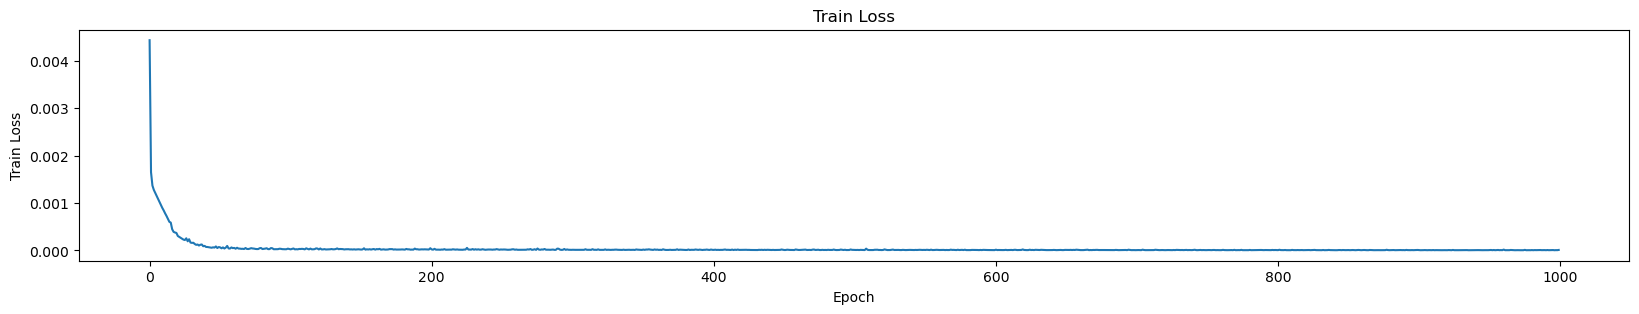

Minimal Train Loss: 5.862071247975109e-06 [996]



In [9]:
# Train Loss Plot
Train_Loss_Plot(loss_list)

In [13]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])
SACed_spectro = torch.tensor([])
Clean_spectro = torch.tensor([])

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)

        y_pred = model(x) # y_pred : B x T

        # # 각 배치 항목에 대해 FFT를 수행하고 스펙트럼 계산
        # batch_size, seq_len = y.shape
        # y = y.view(batch_size, -1).cpu()
        # y_pred = y_pred.view(batch_size, -1).cpu()
        # print("y.shape:", y.shape)

        # _, y_welch = welch(y.numpy(), fs, nperseg=256, noverlap=128, window='hann')
        # _, y_pred_welch = welch(y.numpy(), fs, nperseg=256, noverlap=128, window='hann')
        # print("y_welch.shape:", y_welch.shape)

        # loss = criterion(y_pred, y, y_pred_welch, y_welch)
        
        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.squeeze().cpu()), 0)
        Clean = torch.cat((Clean, y.squeeze().cpu()), 0)
        # SACed_spectro = torch.cat((SACed_spectro, y_pred_welch.cpu()), 0)
        # Clean_spectro = torch.cat((Clean_spectro, y_welch.cpu()), 0)

# val_loss = criterion(SACed, Clean, SACed_spectro, Clean_spectro)
# print(f'Test Loss: {val_loss.item()}')           

torch.Size([32, 1, 4000]) torch.Size([32, 1, 4000])
torch.Size([32, 1, 4000]) torch.Size([32, 1, 4000])
torch.Size([32, 1, 4000]) torch.Size([32, 1, 4000])
torch.Size([32, 1, 4000]) torch.Size([32, 1, 4000])
torch.Size([32, 1, 4000]) torch.Size([32, 1, 4000])
torch.Size([32, 1, 4000]) torch.Size([32, 1, 4000])
torch.Size([8, 1, 4000]) torch.Size([8, 1, 4000])


<Time Domain Error>
Mean Absolute Error: 0.07524468731175382
Mean Squared Error: 0.010048625731506968


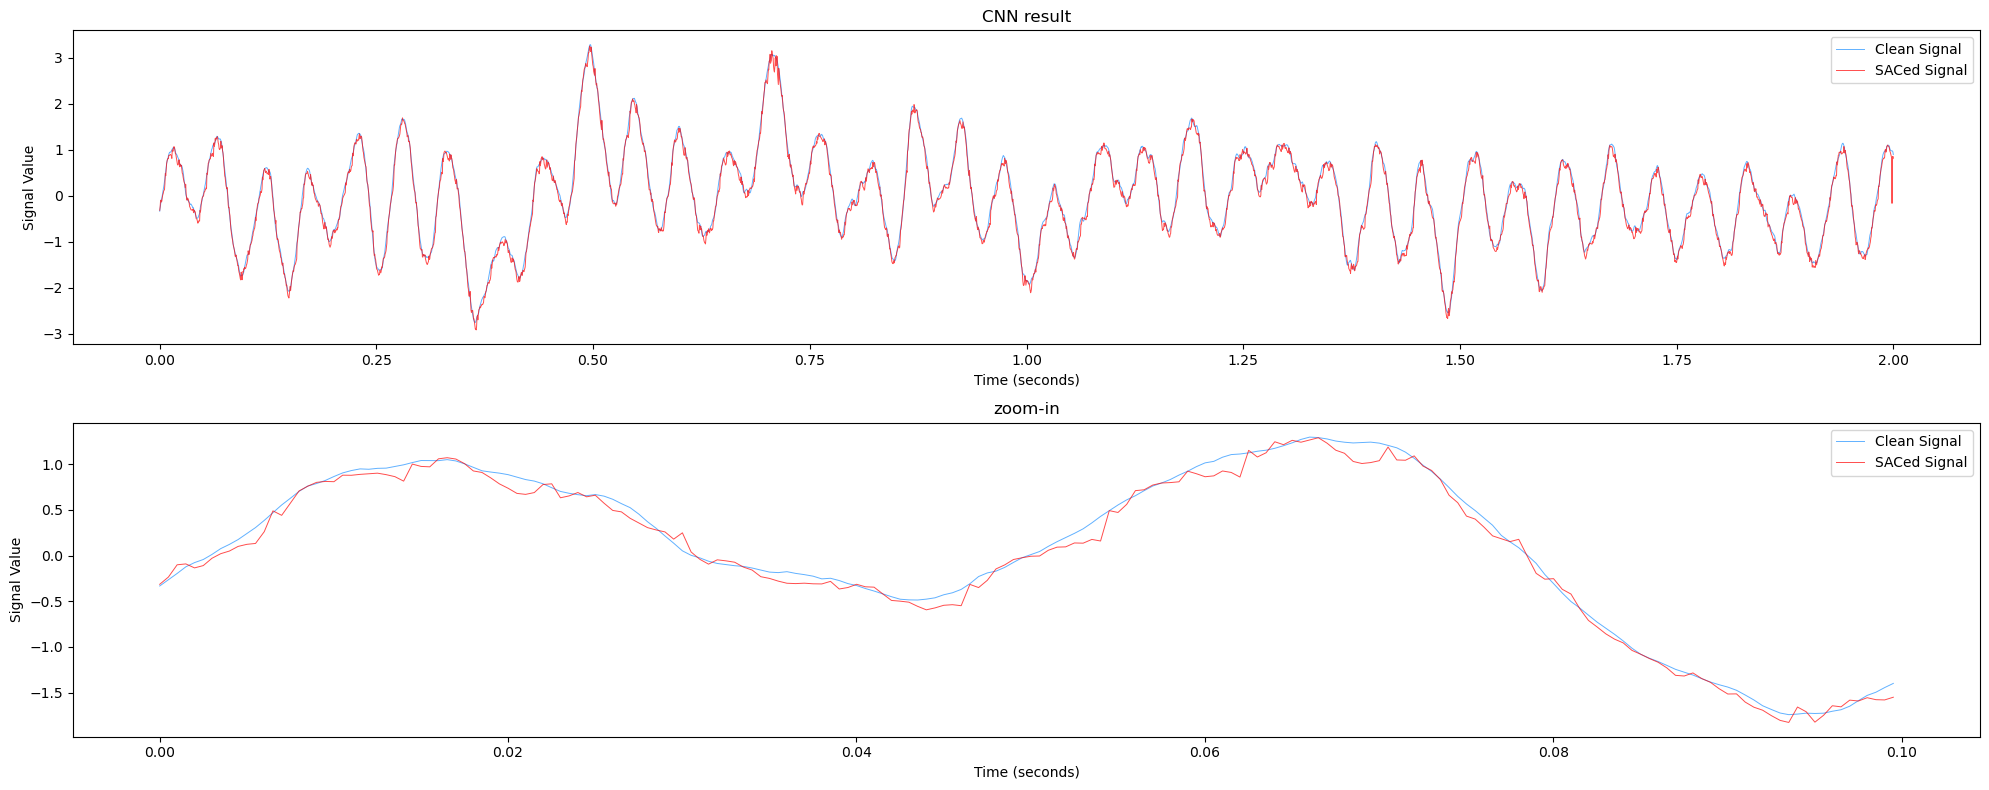

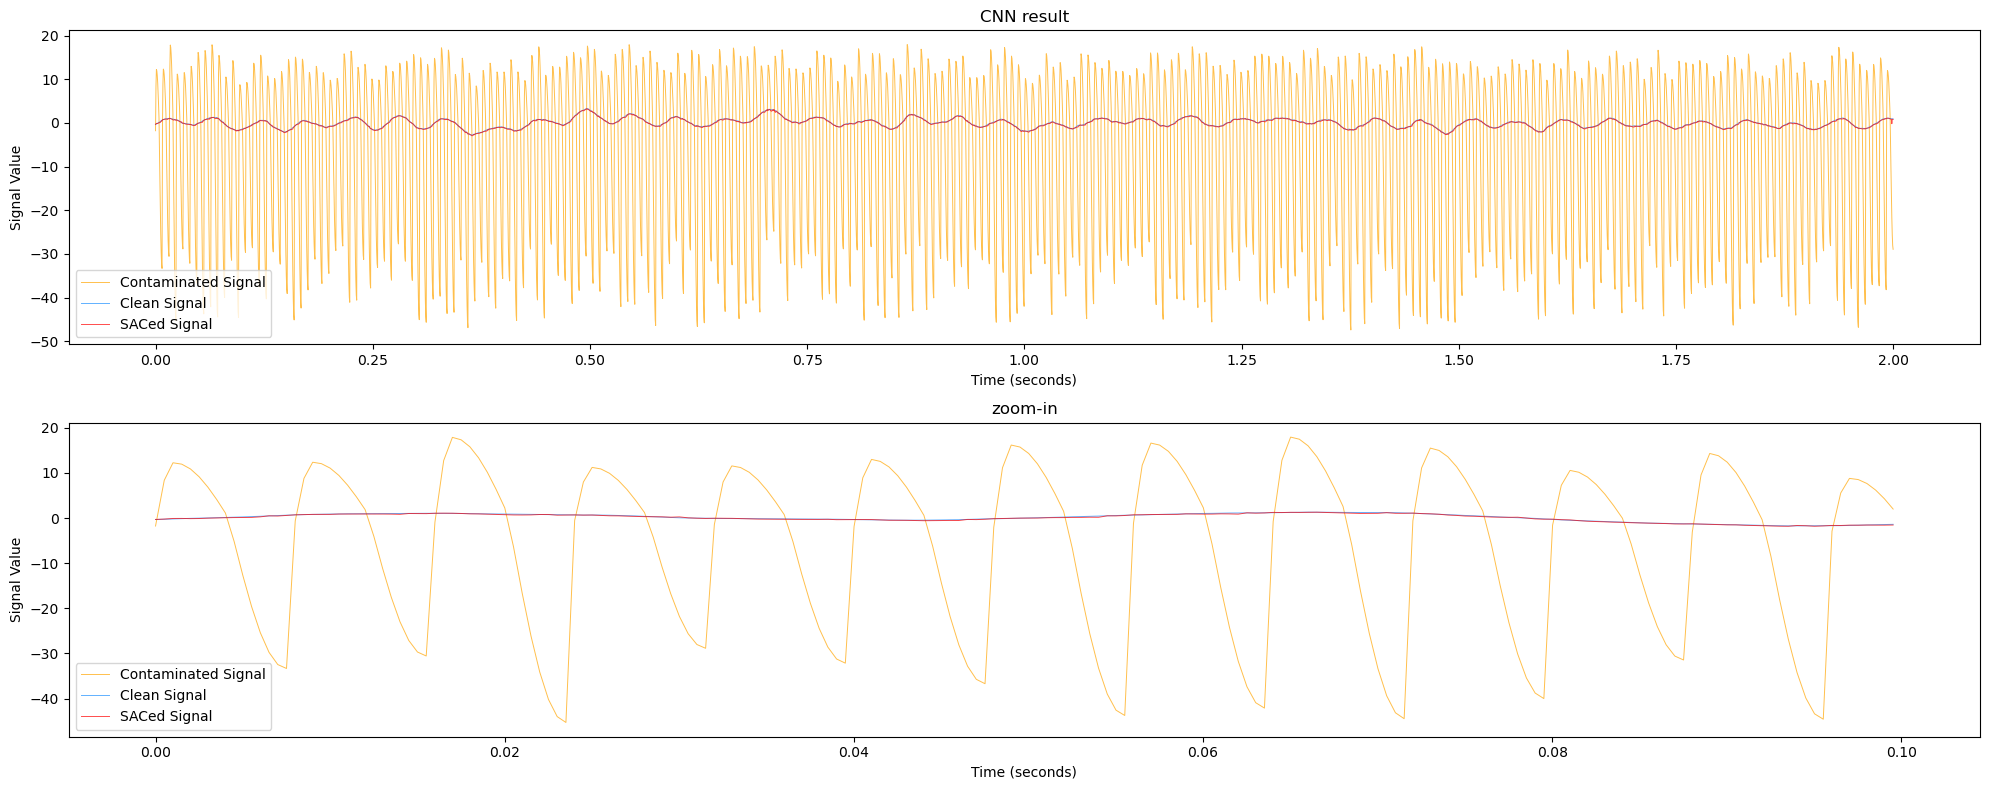

<Frequency Domain Error>
Mean Absolute Error: 0.8031818777844124
Mean Squared Error: 1.1911423454064585


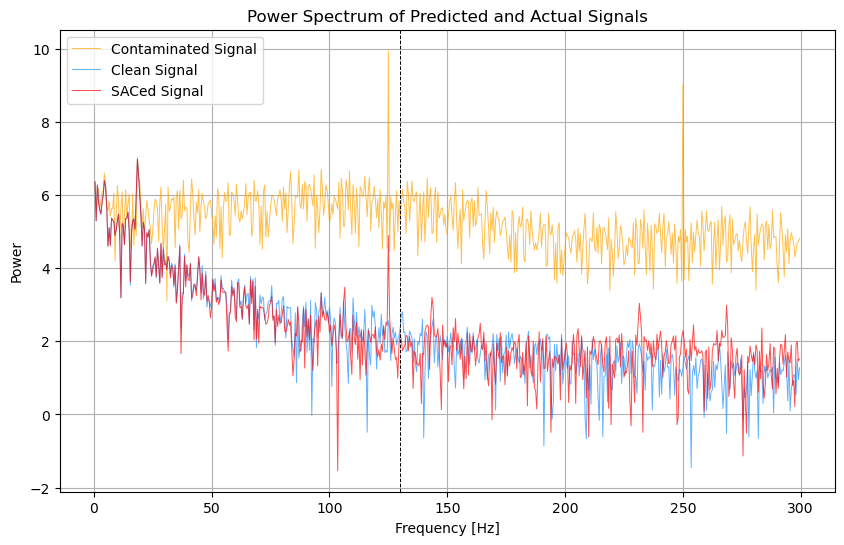

In [11]:
# Inverse Scaling
Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled = time_inv_scaling(Contaminated, SACed, Clean, scaler_x)

# 결과 Plot
Result_Plot(Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled) # inverse scaled data를 input으로 넣음

<Time Domain Error>
Mean Absolute Error: 0.0040437206625938416
Mean Squared Error: 2.9021326554357074e-05


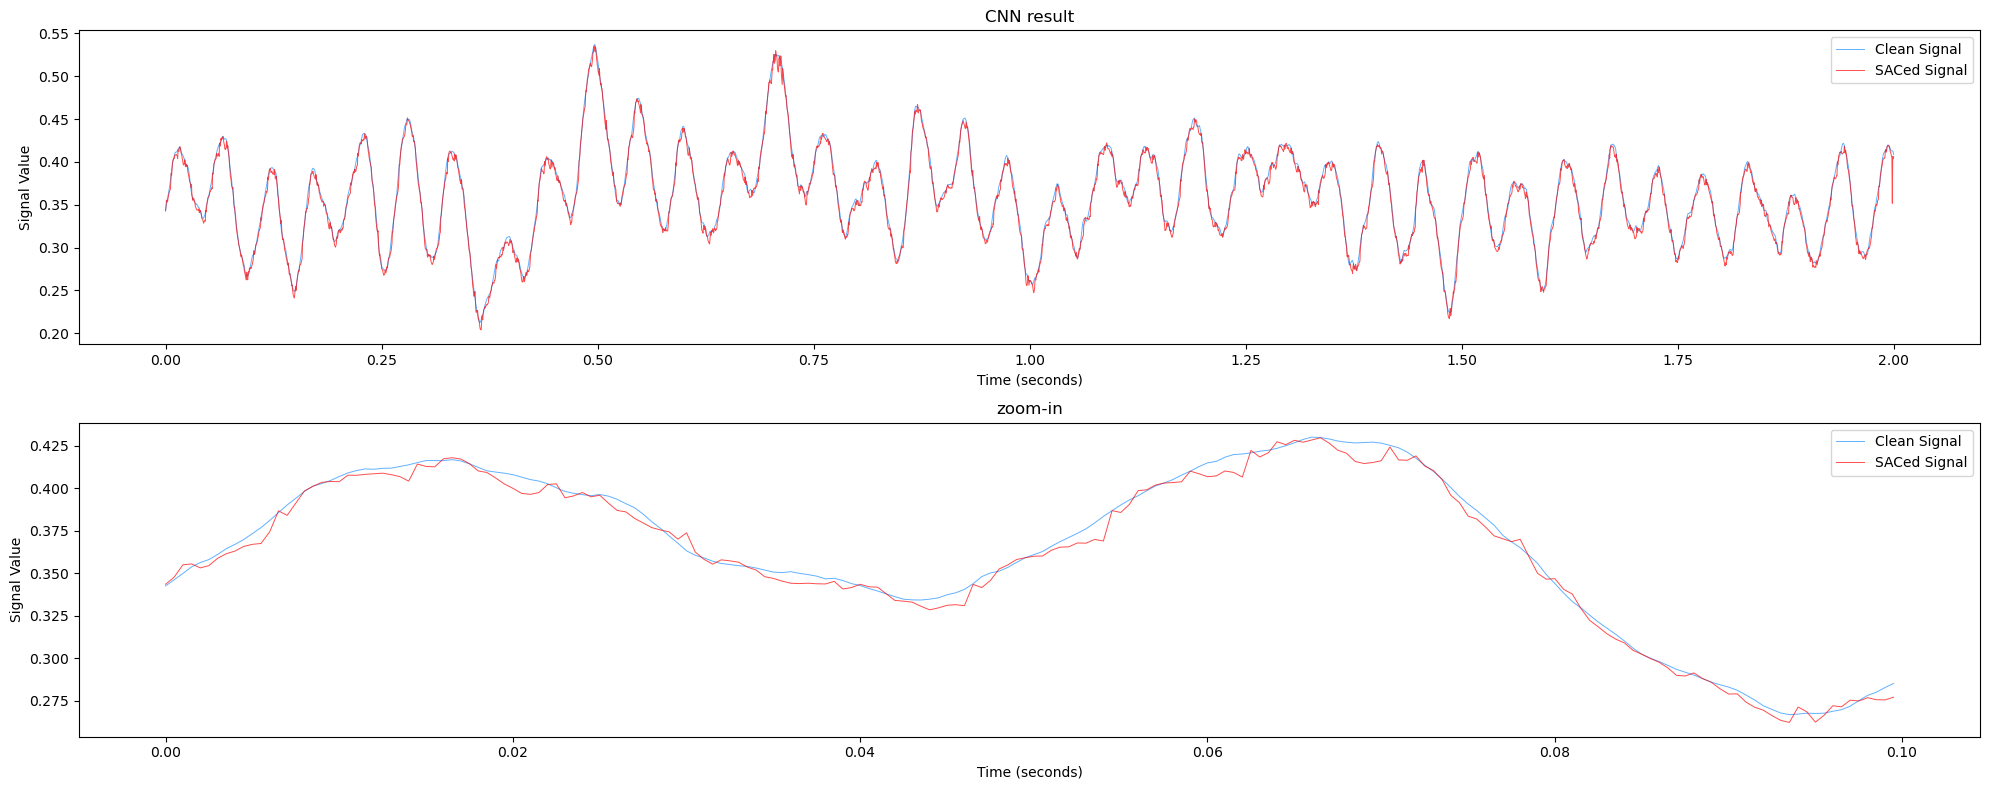

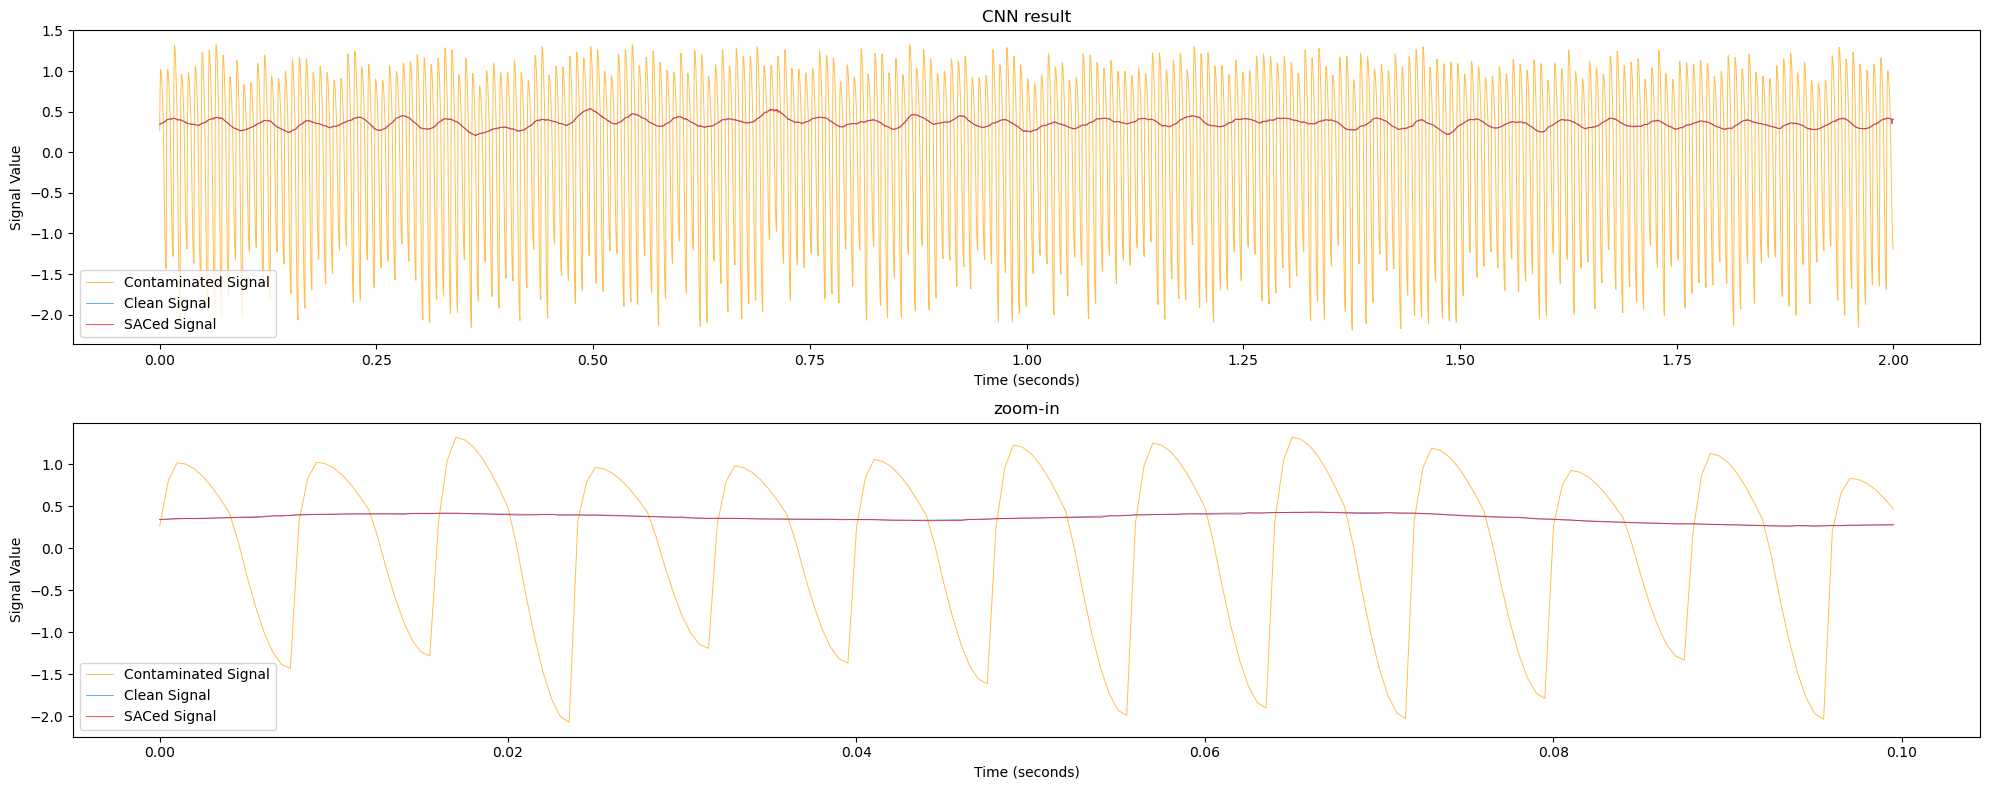

<Frequency Domain Error>
Mean Absolute Error: 0.7956052255805489
Mean Squared Error: 1.07573999157221


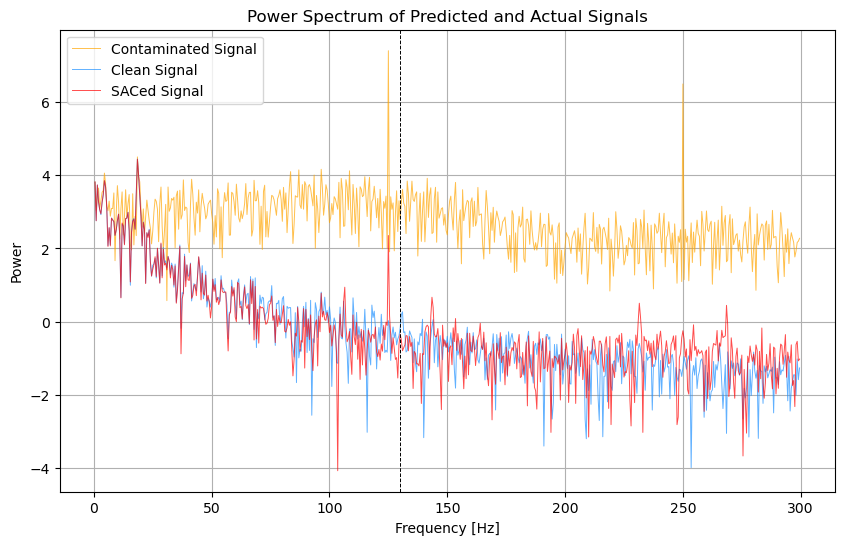

In [12]:
# 원래 scale
Result_Plot(Contaminated, SACed, Clean)